# Revised Simplex Algorithm for minimization problem by Sunyoung An

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
np.set_printoptions(threshold=np.inf, linewidth=np.inf, suppress=True)
sns.set_style('darkgrid')

In [ ]:
class RevisedSimplex(object):

    def __init__(self, A: np.ndarray, b_t: np.ndarray, c_t: np.ndarray, basis_inds: np.ndarray, rule: str = 'bland', verbose: bool = False) -> None:
        self.A = A
        self.b_t = b_t.reshape(1, -1)
        self.c_t = c_t.reshape(1, -1)
        self.basis_inds = np.copy(basis_inds)
        assert rule == 'dantzig' or rule == 'bland'
        self.rule = rule
        self.verbose = verbose

        self.solution = None
        self.history_basis = [self.basis_inds + 1]

        if self.verbose:
            print('A')
            print(self.A)
            print('b')
            print(self.b_t)
            print('c')
            print(self.c_t)
            print('Initial basis')
            print(self.history_basis[0])

    def step(self) -> str:
        nonbasis_inds = np.array([i for i in range(self.c_t.shape[1]) if i not in self.basis_inds])

        Ab = self.A[:, self.basis_inds]
        Ab_inv = np.linalg.inv(Ab)

        xb = np.matmul(Ab_inv, self.b_t.reshape(-1))

        cb_t = self.c_t[:, self.basis_inds]

        p_t = np.matmul(cb_t, Ab_inv)

        cNbar_t = self.c_t[:, nonbasis_inds] - np.matmul(p_t, self.A[:, nonbasis_inds])

        if np.all(cNbar_t >= 0):
            self.solution = np.zeros_like(self.c_t).reshape(-1).astype(float)
            self.solution[self.basis_inds] = xb
            self.history_basis = np.stack(self.history_basis, axis=0)
            return "optimal"  # we should treat properly 'optimal' and 'unbounded'

        # enters basis
        if self.rule == 'dantzig':
            enter_idx = nonbasis_inds[np.argmin(cNbar_t)]
        elif self.rule == 'bland':
            enter_idx = nonbasis_inds[np.argmax(cNbar_t < 0)]  # argmax just to find the first occurence of cNbar_t < 0
        else:
            raise ValueError

        # leaves basis
        Abar_j = np.matmul(Ab_inv, self.A[:, enter_idx])

        if np.all(Abar_j <= 0):
            return 'unbounded'

        positive_idx = np.nonzero(Abar_j > 0)[0]
        theta = xb[positive_idx] / Abar_j[positive_idx]  # if the clipped a_ij is 0, theta_i will be np.inf
        leave_idx = self.basis_inds[positive_idx[np.argmin(theta)]]

        # update basis
        self.basis_inds[self.basis_inds == leave_idx] = enter_idx
        self.history_basis.append(self.basis_inds + 1)

        return 'continue'

    def solve(self) -> None:
        if self.verbose:
            print()
            print('Start!')

        result = 'continue'
        while result == 'continue':
            result = self.step()

        if self.verbose:
            print('Result: {}'.format(result))
            if result == 'optimal':
                print('The solution found:')
                print(self.solution)
                print('Basis Path')
                print(self.history_basis)

        return result


# Define the problem

In [ ]:
# convert the LP into standard from by adding slack variables.
N = 8
c = []
A = []
b = []
for i in range(1, N+1):
    c.append(-3**(N-i))
    A.append([0]*(N*2))
    A[i-1][i-1] = 1
    A[i-1][i+7] = 1
    for j in range(i-1):
        A[i-1][j] = 2*3**(i-j-1)
    b.append(3**(2*i-2))

c += [0]*8

In [ ]:
A

[[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [6, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [18, 6, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [54, 18, 6, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [162, 54, 18, 6, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [486, 162, 54, 18, 6, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [1458, 486, 162, 54, 18, 6, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [4374, 1458, 486, 162, 54, 18, 6, 1, 0, 0, 0, 0, 0, 0, 0, 1]]

In [ ]:
b

[1, 9, 81, 729, 6561, 59049, 531441, 4782969]

In [ ]:
c

[-2187, -729, -243, -81, -27, -9, -3, -1, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
A = np.array(A)
b = np.array(b)
c = np.array(c)

# Example 1: Revised simplex using the slack variables as the initial basis

In [ ]:
basis_inds = [9, 10, 11, 12, 13, 14, 15, 16]
basis_inds = np.array(basis_inds) - 1  # zero-based

# Dantzig's Pivoting Rules

Enter: the smallest negative reduced cost

Leave: min-theta, and if there is a min-theta tie, pick the variable with smallest index

In [ ]:
rsm_dantzig = RevisedSimplex(A, b, c, basis_inds, rule='dantzig', verbose=True)
_ = rsm_dantzig.solve()

A
[[   1    0    0    0    0    0    0    0    1    0    0    0    0    0    0    0]
 [   6    1    0    0    0    0    0    0    0    1    0    0    0    0    0    0]
 [  18    6    1    0    0    0    0    0    0    0    1    0    0    0    0    0]
 [  54   18    6    1    0    0    0    0    0    0    0    1    0    0    0    0]
 [ 162   54   18    6    1    0    0    0    0    0    0    0    1    0    0    0]
 [ 486  162   54   18    6    1    0    0    0    0    0    0    0    1    0    0]
 [1458  486  162   54   18    6    1    0    0    0    0    0    0    0    1    0]
 [4374 1458  486  162   54   18    6    1    0    0    0    0    0    0    0    1]]
b
[[      1       9      81     729    6561   59049  531441 4782969]]
c
[[-2187  -729  -243   -81   -27    -9    -3    -1     0     0     0     0     0     0     0     0]]
Initial basis
[ 9 10 11 12 13 14 15 16]

Start!
Result: optimal
The solution found:
[      0.       0.       0.       0.       0.       0.       0. 4782969.     

# Bland's Pivoting Rules

Enter/Leave: Among valid, the smallest variable index

In [ ]:
rsm_bland = RevisedSimplex(A, b, c, basis_inds, rule='bland', verbose=True)
_ = rsm_bland.solve()

A
[[   1    0    0    0    0    0    0    0    1    0    0    0    0    0    0    0]
 [   6    1    0    0    0    0    0    0    0    1    0    0    0    0    0    0]
 [  18    6    1    0    0    0    0    0    0    0    1    0    0    0    0    0]
 [  54   18    6    1    0    0    0    0    0    0    0    1    0    0    0    0]
 [ 162   54   18    6    1    0    0    0    0    0    0    0    1    0    0    0]
 [ 486  162   54   18    6    1    0    0    0    0    0    0    0    1    0    0]
 [1458  486  162   54   18    6    1    0    0    0    0    0    0    0    1    0]
 [4374 1458  486  162   54   18    6    1    0    0    0    0    0    0    0    1]]
b
[[      1       9      81     729    6561   59049  531441 4782969]]
c
[[-2187  -729  -243   -81   -27    -9    -3    -1     0     0     0     0     0     0     0     0]]
Initial basis
[ 9 10 11 12 13 14 15 16]

Start!
Result: optimal
The solution found:
[      0.       0.       0.       0.       0.       0.       0. 4782969.     

In [ ]:
## to check the correctness of my implementation
from scipy.optimize import linprog
# Note that by default lb = 0 and ub = None unless specified with bounds.
result_sp = linprog(c=c, A_eq=A, b_eq=b)
print('Reference SciPy Solution:')
print(result_sp.x)
print('My solution using Dantzig’s pivoting rules:')
print(rsm_dantzig.solution)
print('My solution using Bland’s pivoting rules:')
print(rsm_bland.solution)

Reference SciPy Solution:
[      0.       0.       0.       0.       0.       0.       0. 4782969.       1.       9.      81.     729.    6561.   59049.  531441.       0.]
My solution using Dantzig’s pivoting rules:
[      0.       0.       0.       0.       0.       0.       0. 4782969.       1.       9.      81.     729.    6561.   59049.  531441.       0.]
My solution using Bland’s pivoting rules:
[      0.       0.       0.       0.       0.       0.       0. 4782969.       1.       9.      81.     729.    6561.   59049.  531441.       0.]


# Example 2: Revised simplex using random initial basis

In [ ]:
num_trials = 1000
num_bases_visited_dantzig = []
num_bases_visited_bland = []

# Dantzig's Pivoting Rules

Enter: the smallest negative reduced cost

Leave: min-theta, and if there is a min-theta tie, pick the variable with smallest index

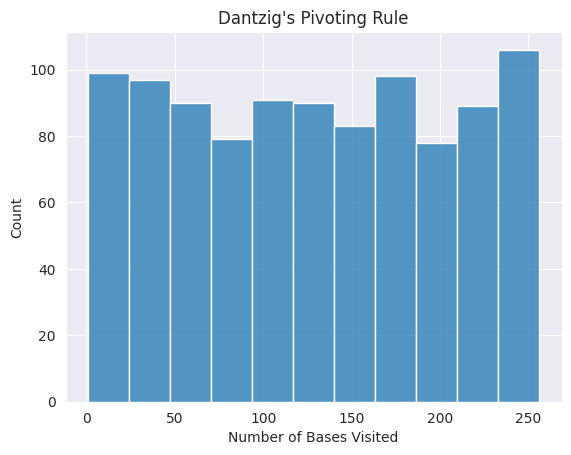

In [ ]:
num_success = 0
while num_success < num_trials:
    # random column indices to form a basis
    rnd_basis_inds = np.random.choice(A.shape[1], A.shape[0], replace=False)
    Arb = A[:, rnd_basis_inds]

    ## BFS Check
    # 1. invertible check
    if np.linalg.det(Arb) == 0 or np.linalg.matrix_rank(Arb) != Arb.shape[0]:
        continue

    # 2. non-negativity check
    Arb_inv = np.linalg.inv(Arb)
    xb = np.matmul(Arb_inv, b)
    if np.any(xb < 0):
        continue

    # solve
    rsm = RevisedSimplex(A, b, c, rnd_basis_inds, rule='dantzig', verbose=False)
    result = rsm.solve()

    if result == 'optimal':
        num_bases_visited_dantzig.append(len(rsm.history_basis))
        num_success += 1

plt.figure()
g_dantzig = sns.histplot(num_bases_visited_dantzig)
g_dantzig.set_xlabel('Number of Bases Visited')
g_dantzig.set_title("Dantzig's Pivoting Rule")
plt.show()

# Bland's Pivoting Rules

Enter/Leave: Among valid, the smallest variable index

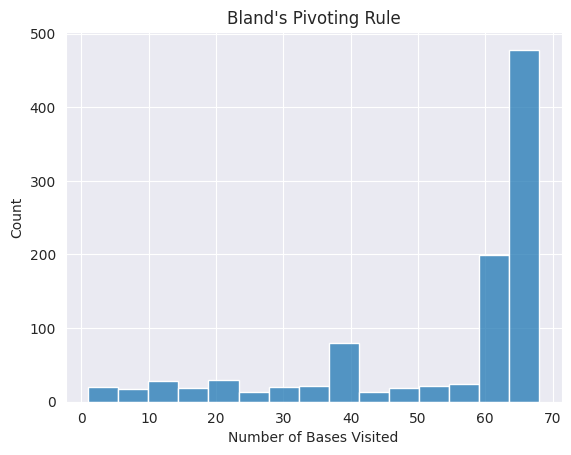

In [ ]:
num_success = 0
while num_success < num_trials:
    # random column indices to form a basis
    rnd_basis_inds = np.random.choice(A.shape[1], A.shape[0], replace=False)
    Arb = A[:, rnd_basis_inds]

    ## BFS Check
    # 1. invertible check
    if np.linalg.det(Arb) == 0 or np.linalg.matrix_rank(Arb) != Arb.shape[0]:
        continue

    # 2. non-negativity check
    Arb_inv = np.linalg.inv(Arb)
    xb = np.matmul(Arb_inv, b)
    if np.any(xb < 0):
        continue

    # solve
    rsm = RevisedSimplex(A, b, c, rnd_basis_inds, rule='bland', verbose=False)
    result = rsm.solve()

    if result == 'optimal':
        num_bases_visited_bland.append(len(rsm.history_basis))
        num_success += 1

plt.figure()
g_bland = sns.histplot(num_bases_visited_bland)
g_bland.set_xlabel('Number of Bases Visited')
g_bland.set_title("Bland's Pivoting Rule")
plt.show()